## This notebook contains code relevant to model.fit

#### run code in common notebook

In [ ]:
%run 0_common.ipynb

2023-08-14 02:23:04.600359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: U

7
<class 'list'>
['NDVI', 'Lai', 'SoilMoi00_10cm_tavg', 'LST_Day_1km', 'total_precipitation', 'u_component_of_wind_10m', 'v_component_of_wind_10m', 'T21']


In [ ]:
FOLDER = 'fcnn-demo'

### Read and parse tfrecord from Google Cloud Storage

In [ ]:
def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  # print(f'Example Proto: {example_proto}')
  parsed_features = tf.io.parse_single_example(example_proto, FEATURES_DICT)
  # print(f'Parsed features: {parsed_features}')
  # print()
  return parsed_features

def to_tuple(inputs, deb=True):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in FEATURE_NAMES]
  stacked = tf.stack(inputsList, axis=0)

  if deb:
    print(f'to_tuple inputsList {inputsList}')
    print(f'to_tuple len list {len(inputsList)}')
    print(f'to_tuple stacked shape {stacked.shape}')

  # Convert from CHW to HWC
  # See https://caffe2.ai/docs/tutorial-image-pre-processing.html
  stacked = tf.transpose(stacked, [1, 2, 0])

  if deb:
    print(f'to_tuple after reshape {stacked.shape}')
    print(f'length of BANDS??? {len(BANDS)}')
  return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]

In [ ]:
# visualize tfrecord
import matplotlib.pyplot as plt

def visualize_dataset(dataset):
  for batch in dataset.take(10):
    # print(f'Batch keys: {batch.keys()}')
    # print(f'Batch data types: {[type(v.numpy()) for v in batch.values()]}')
    f, axarr = plt.subplots(4, 2)
    rows = np.repeat([0, 1, 2, 3], 2)
    cols = np.repeat([[0, 1]], 4, axis=0).ravel()
    for v, r, c in zip(batch.values(), rows, cols):
      axarr[r, c].imshow(v, cmap='gray')

def get_dataset(pattern):
  """Function to read, parse and format to tuple a set of input tfrecord files.
  Get all the files matching the pattern, parse and convert to tuple.
  Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
  Returns:
    A tf.data.Dataset
  """
  glob = tf.io.gfile.glob(pattern)
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  # print(f'get_dataset:parse step1 {dataset}')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  # print(f'get_dataset step1-2 {dataset.element_spec}')
  # for batch in dataset.take(1):
  #   print("Batch keys:", batch.keys())
  #   for key, value in batch.items():
  #       print(f"Key: {key}, Shape: {value.shape}, Data Type: {value.dtype}")
    
  visualize_dataset(dataset)
  # print(f'get_dataset step2 {dataset}')
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  # print(f'get_dataset step3 {dataset}')
  return dataset

In [ ]:
def get_training_dataset(filename_pattern):
    """Get the preprocessed training dataset
    Returns:
    A tf.data.Dataset of training data.
    """
    glob = filename_pattern
    dataset = get_dataset(glob)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    # visualize_dataset(dataset)
    return dataset

def get_eval_dataset(filename_pattern):
	"""Get the preprocessed training dataset
  Returns:
    A tf.data.Dataset of training data.
  """
	glob = filename_pattern
	dataset = get_dataset(glob)
	dataset = dataset.batch(1).repeat()
	return dataset

#### Inspect fire and no fire data separately

2023-08-14 05:01:16.465504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3]
	 [[{{node Placeholder/_0}}]]


to_tuple inputsList [<tf.Tensor 'args_2:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_1:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_3:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_0:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_5:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_6:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_7:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_4:0' shape=(256, 256) dtype=float32>]
to_tuple len list 8
to_tuple stacked shape (8, 256, 256)
to_tuple after reshape (256, 256, 8)
length of BANDS??? 7


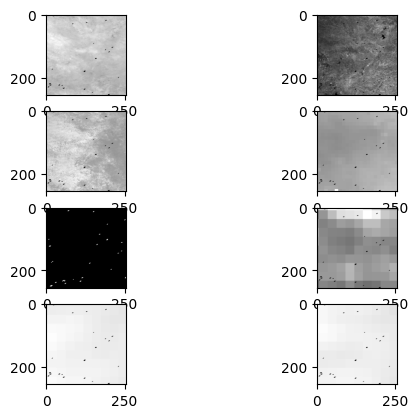

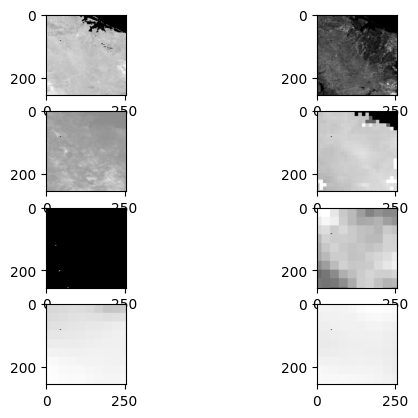

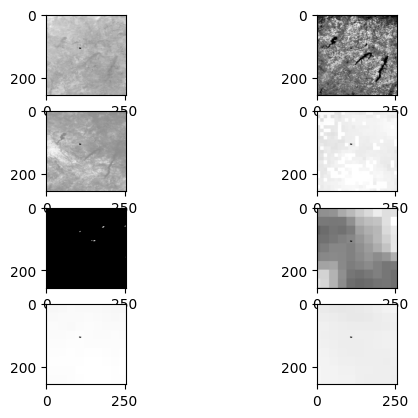

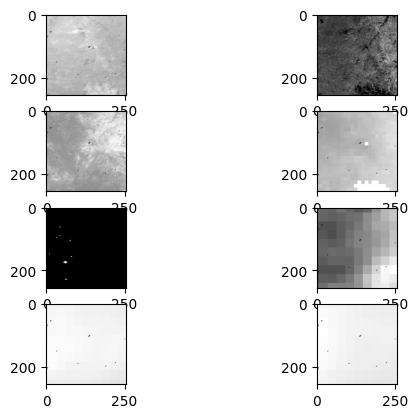

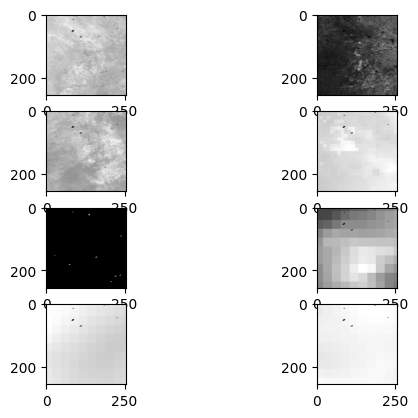

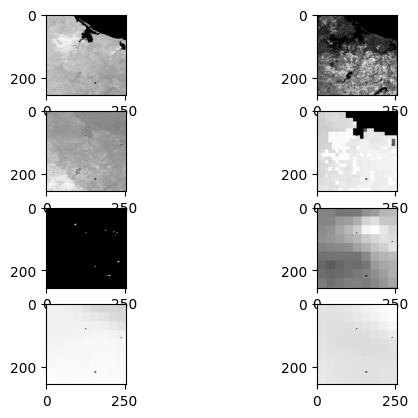

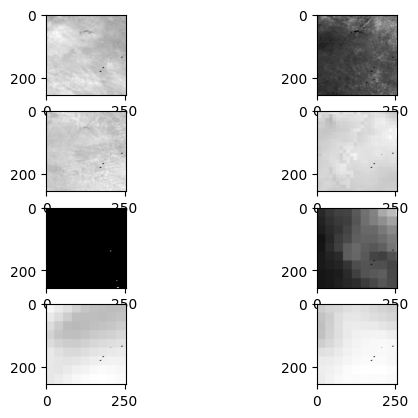

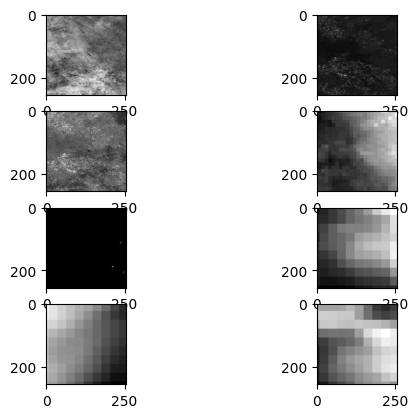

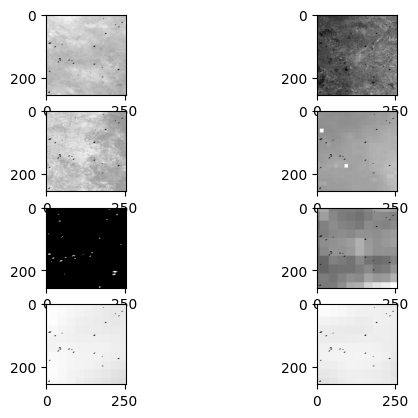

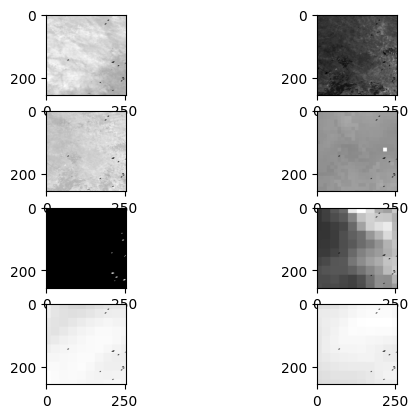

In [ ]:
training_nofire = get_training_dataset('gs://' + DATA_BUCKET + '/' + FOLDER + '/pixel_10_data/' + 'training*' + '*_nofire*')

2023-08-14 05:01:45.525609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [16]
	 [[{{node Placeholder/_0}}]]


to_tuple inputsList [<tf.Tensor 'args_2:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_1:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_3:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_0:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_5:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_6:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_7:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_4:0' shape=(256, 256) dtype=float32>]
to_tuple len list 8
to_tuple stacked shape (8, 256, 256)
to_tuple after reshape (256, 256, 8)
length of BANDS??? 7


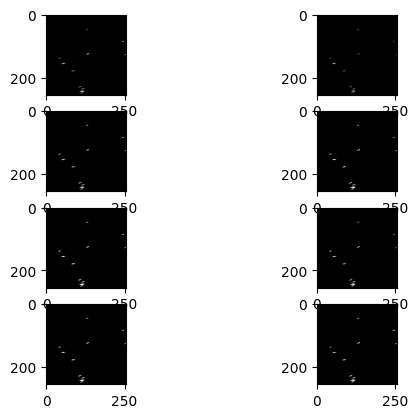

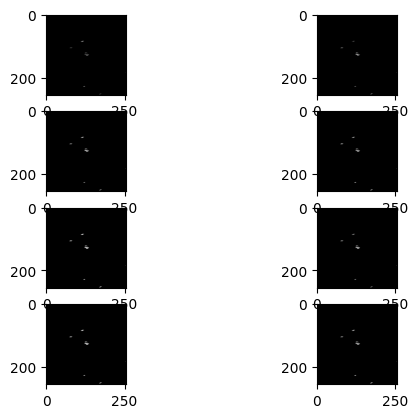

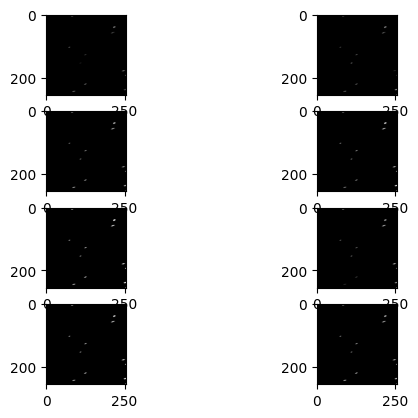

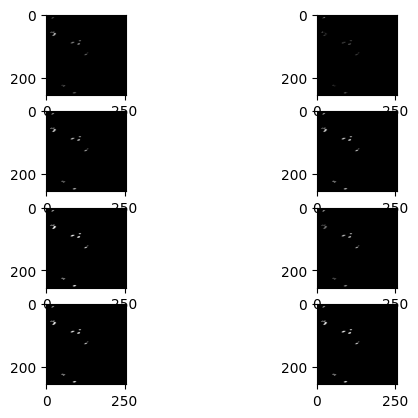

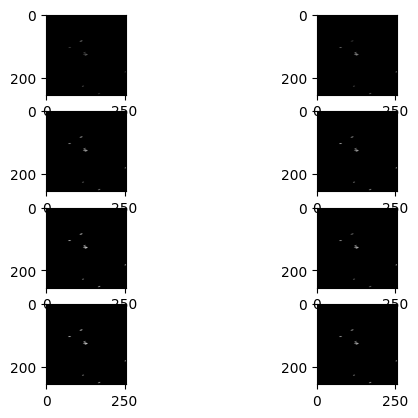

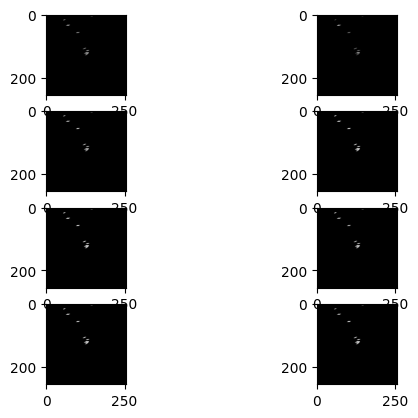

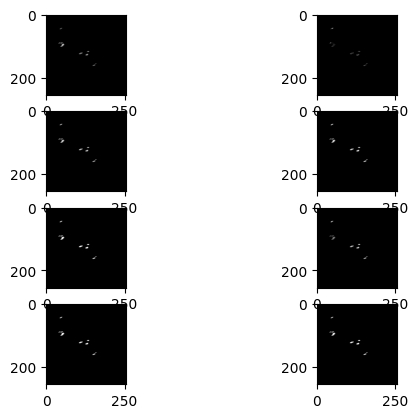

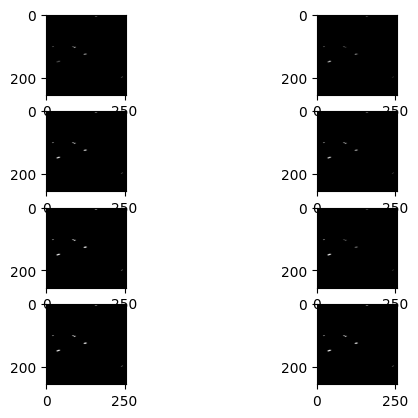

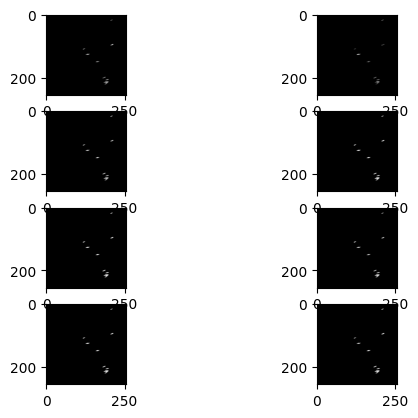

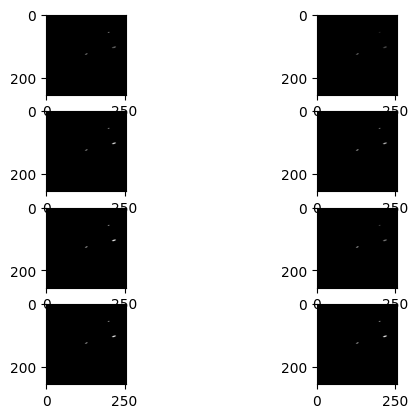

In [ ]:
training_fire = get_training_dataset('gs://' + DATA_BUCKET + '/' + FOLDER + '/pixel_10_data/' + 'training*' + '*_fire*')

2023-08-14 05:01:58.966865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [24]
	 [[{{node Placeholder/_0}}]]


to_tuple inputsList [<tf.Tensor 'args_2:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_1:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_3:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_0:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_5:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_6:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_7:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_4:0' shape=(256, 256) dtype=float32>]
to_tuple len list 8
to_tuple stacked shape (8, 256, 256)
to_tuple after reshape (256, 256, 8)
length of BANDS??? 7


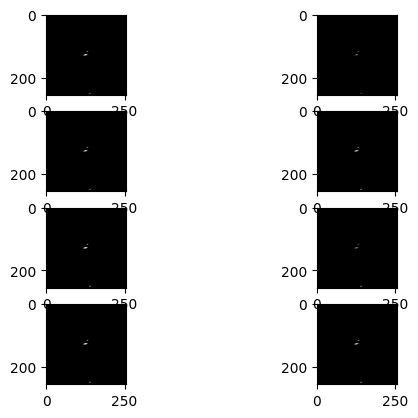

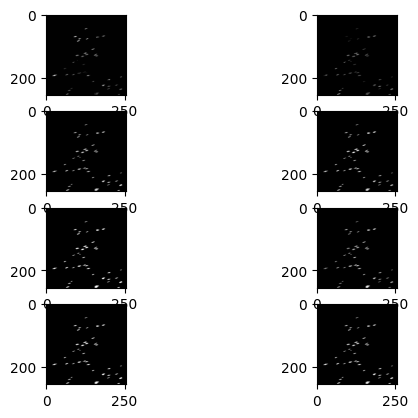

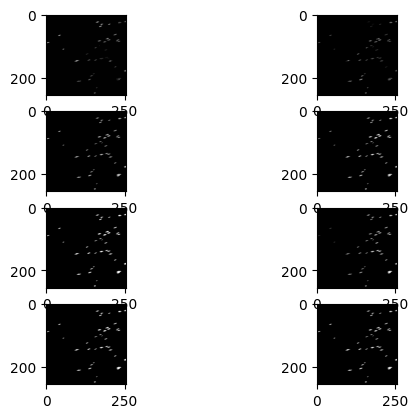

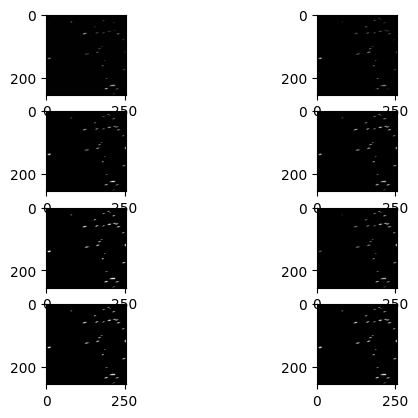

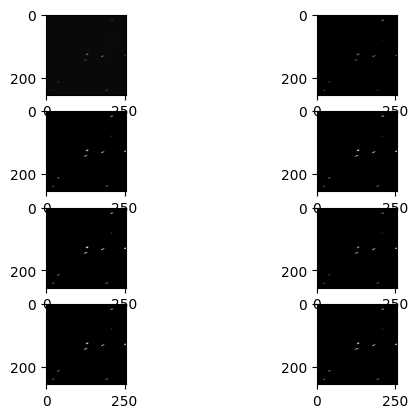

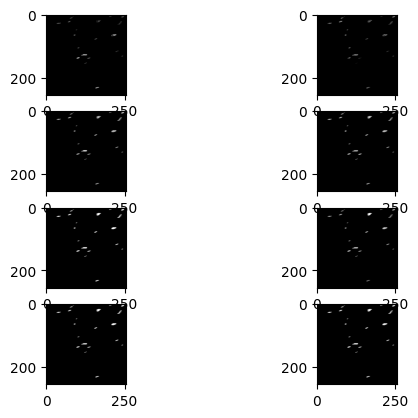

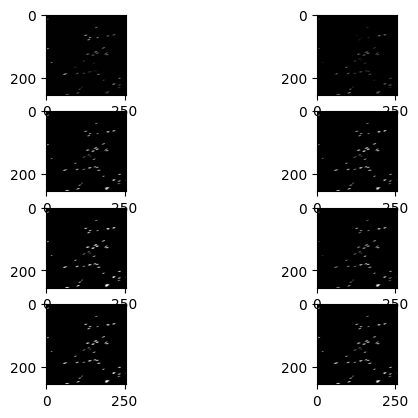

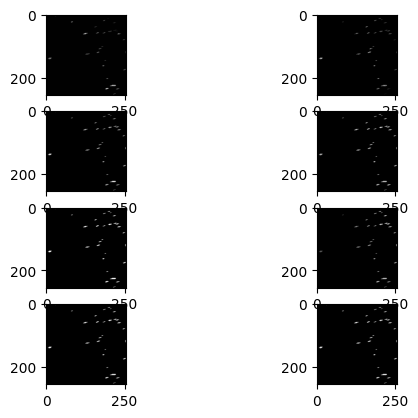

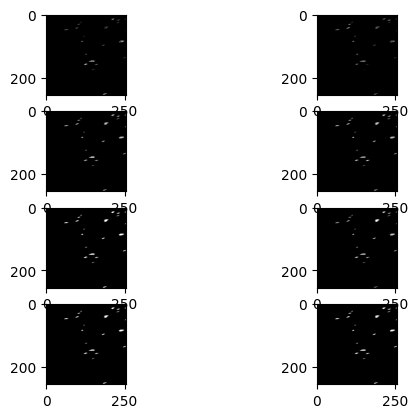

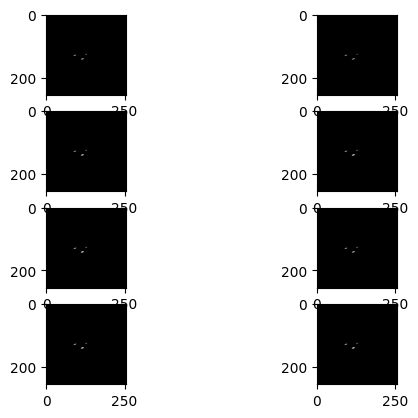

In [ ]:
eval_fire = get_training_dataset('gs://' + DATA_BUCKET + '/' + FOLDER + '/pixel_10_data/' + 'eval*' + '*_fire*')

2023-08-14 05:02:15.220853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3]
	 [[{{node Placeholder/_0}}]]


to_tuple inputsList [<tf.Tensor 'args_2:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_1:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_3:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_0:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_5:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_6:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_7:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_4:0' shape=(256, 256) dtype=float32>]
to_tuple len list 8
to_tuple stacked shape (8, 256, 256)
to_tuple after reshape (256, 256, 8)
length of BANDS??? 7


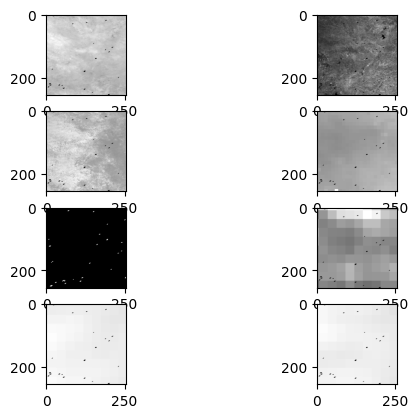

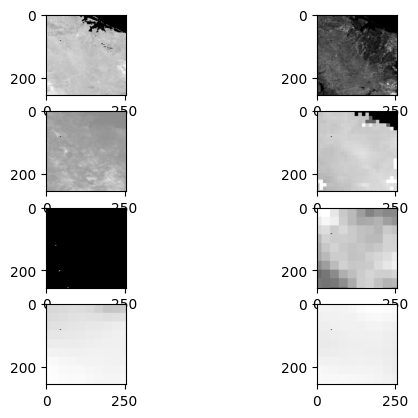

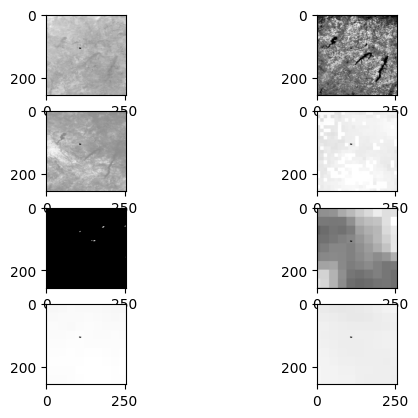

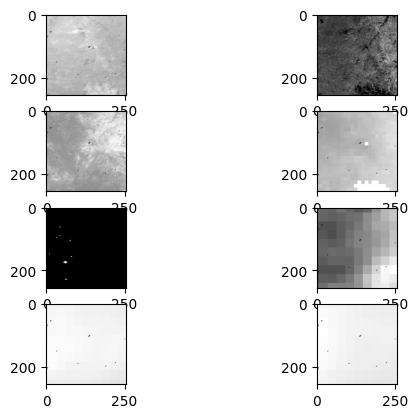

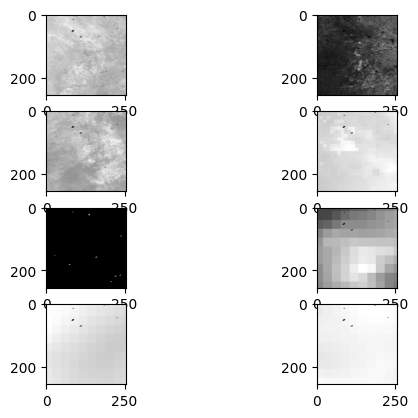

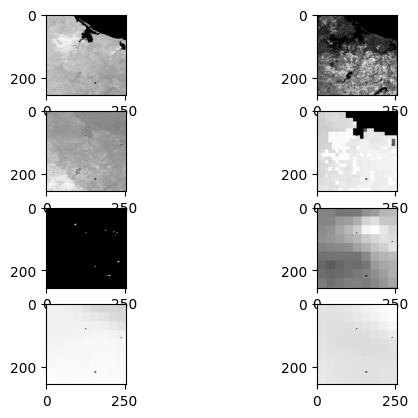

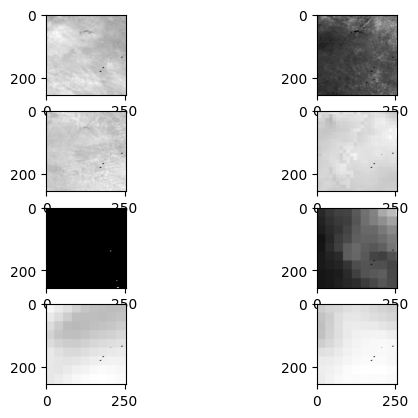

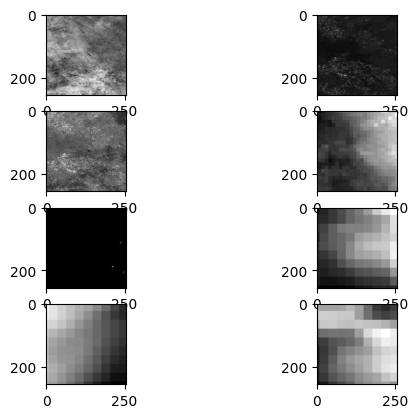

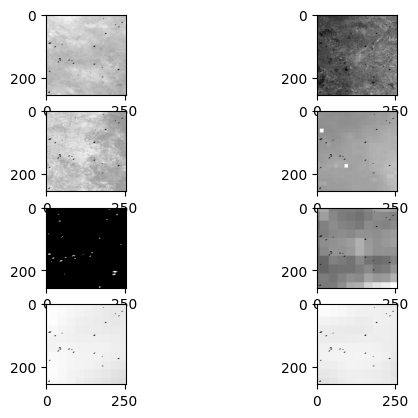

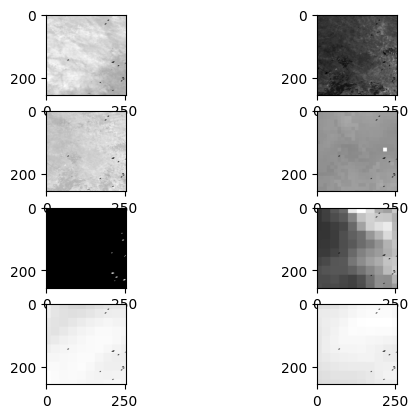

In [ ]:
eval_nofire = get_training_dataset('gs://' + DATA_BUCKET + '/' + FOLDER + '/pixel_10_data/' + 'train*' + '*_nofire*')

#### Get training and evaluation dataset

2023-08-14 04:26:02.073311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [19]
	 [[{{node Placeholder/_0}}]]


to_tuple inputsList [<tf.Tensor 'args_2:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_1:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_3:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_0:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_5:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_6:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_7:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_4:0' shape=(256, 256) dtype=float32>]
to_tuple len list 8
to_tuple stacked shape (8, 256, 256)
to_tuple after reshape (256, 256, 8)
length of BANDS??? 7


2023-08-14 04:26:03.312908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [19]
	 [[{{node Placeholder/_0}}]]
2023-08-14 04:26:03.313724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [19]
	 [[{{node Placeholder/_0}}]]


(<tf.Tensor: shape=(64, 256, 256, 7), dtype=float32, numpy=
array([[[[0.55181557, 0.06666667, 0.18051222, ..., 0.01004475,
          0.54291356, 0.49370465],
         [0.55272996, 0.06666667, 0.18051222, ..., 0.01004475,
          0.54291356, 0.49370465],
         [0.55476946, 0.06666667, 0.18051222, ..., 0.01004475,
          0.54291356, 0.49370465],
         ...,
         [0.58723676, 0.06666667, 0.19587758, ..., 0.02406245,
          0.5373169 , 0.5050894 ],
         [0.5841339 , 0.06666667, 0.19587758, ..., 0.03282928,
          0.54535735, 0.5110407 ],
         [0.5829624 , 0.06666667, 0.19587758, ..., 0.03282928,
          0.54535735, 0.5110407 ]],

        [[0.5530009 , 0.06666667, 0.18051222, ..., 0.01004475,
          0.54291356, 0.49370465],
         [0.55373716, 0.06666667, 0.18051222, ..., 0.01004475,
          0.54291356, 0.49370465],
         [0.55607766, 0.06666667, 0.18051222, ..., 0.01004475,
          0.54291356, 0.49370465],
         ...,
         [0.5868717 , 0.0833

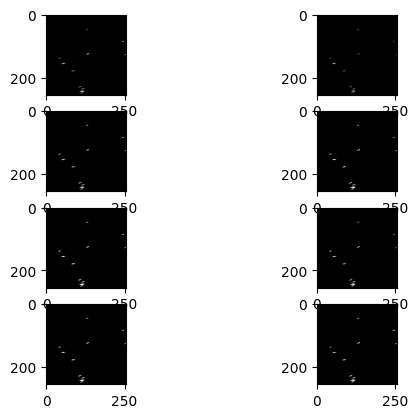

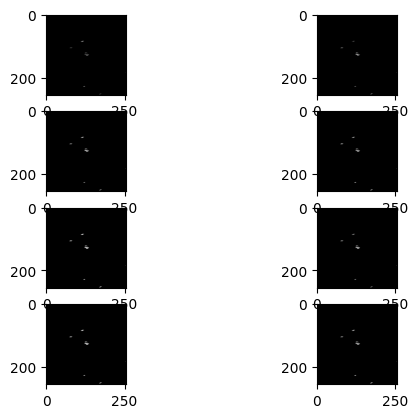

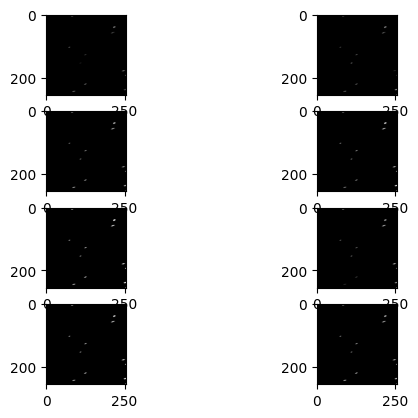

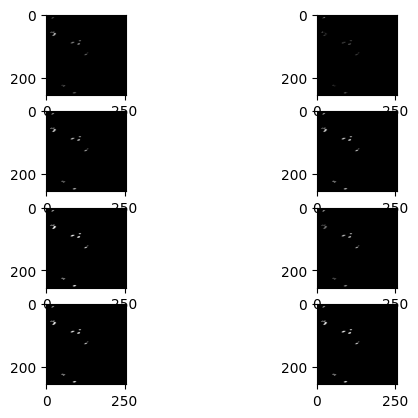

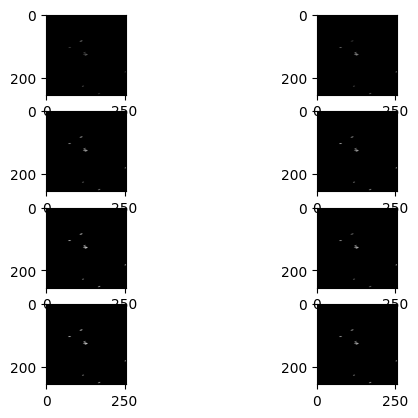

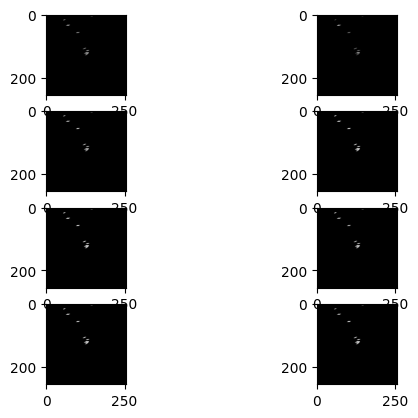

In [ ]:
training = get_training_dataset('gs://' + DATA_BUCKET + '/' + FOLDER + '/pixel_10_data/' + 'training*')
print(iter(training.take(1)).next())

2023-08-14 05:03:20.882348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [27]
	 [[{{node Placeholder/_0}}]]


to_tuple inputsList [<tf.Tensor 'args_2:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_1:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_3:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_0:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_5:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_6:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_7:0' shape=(256, 256) dtype=float32>, <tf.Tensor 'args_4:0' shape=(256, 256) dtype=float32>]
to_tuple len list 8
to_tuple stacked shape (8, 256, 256)
to_tuple after reshape (256, 256, 8)
length of BANDS??? 7


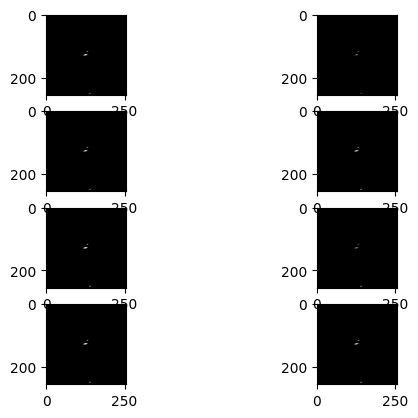

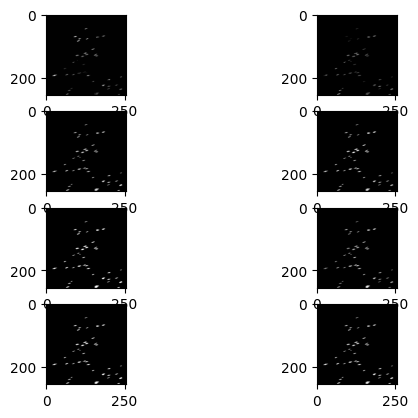

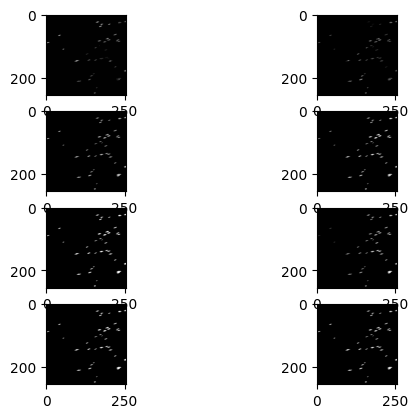

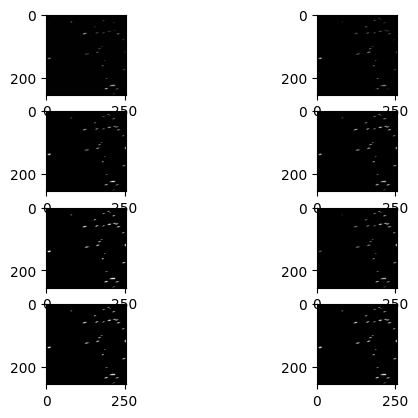

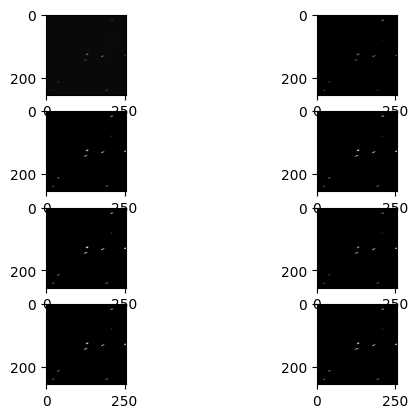

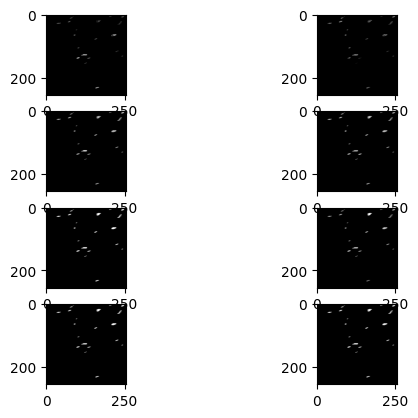

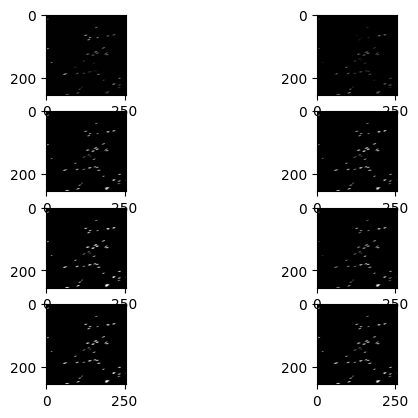

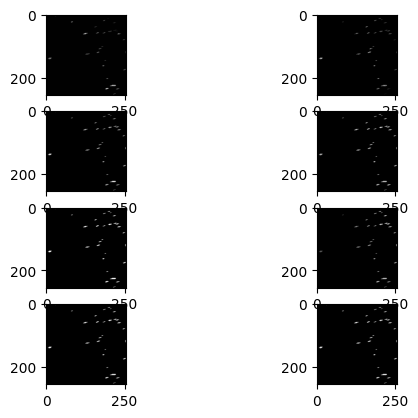

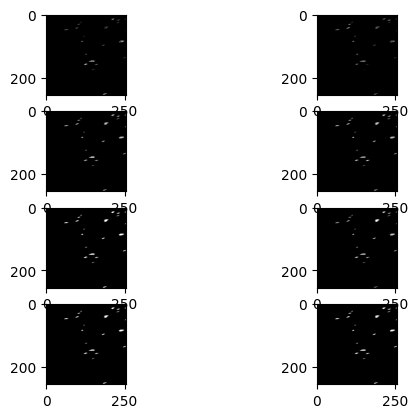

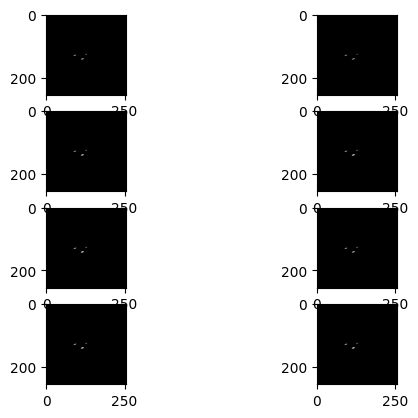

In [ ]:
evaluation = get_eval_dataset('gs://' + DATA_BUCKET + '/' + FOLDER + '/pixel_10_data/' + 'eval*')

unet

### Define U-Net model

In [ ]:
filter_1 = 32
filter_2 = 16

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.models as models
import tensorflow.keras.metrics as metrics
import tensorflow.keras.optimizers as optimizers

#### Original U-Net model

In [ ]:
def conv_block(input_tensor, num_filters):
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	return encoder

def encoder_block(input_tensor, num_filters):
	encoder = conv_block(input_tensor, num_filters)
	encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
	return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
	decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
	decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	return decoder

def get_model(filter_base):
	inputs = layers.Input(shape=[None, None, len(BANDS)]) # 256
	encoder0_pool, encoder0 = encoder_block(inputs, filter_base) # 128
	encoder1_pool, encoder1 = encoder_block(encoder0_pool, filter_base*2) # 64
	encoder2_pool, encoder2 = encoder_block(encoder1_pool, filter_base*4) # 32
	encoder3_pool, encoder3 = encoder_block(encoder2_pool, filter_base*8) # 16
	encoder4_pool, encoder4 = encoder_block(encoder3_pool, filter_base*16) # 8
	center = conv_block(encoder4_pool, filter_base*32) # center
	decoder4 = decoder_block(center, encoder4, filter_base*16) # 16
	decoder3 = decoder_block(decoder4, encoder3, filter_base*8) # 32
	decoder2 = decoder_block(decoder3, encoder2, filter_base*4) # 64
	decoder1 = decoder_block(decoder2, encoder1, filter_base*2) # 128
	decoder0 = decoder_block(decoder1, encoder0, filter_base) # 256
	outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

	model = models.Model(inputs=[inputs], outputs=[outputs])

	model.compile(
		optimizer=optimizers.get(OPTIMIZER),
		loss=losses.get(LOSS),
		metrics=[metrics.get(metric) for metric in METRICS],
		run_eagerly=True
		)

	return model

#### Simplied version 1: reduce layers

In [ ]:
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.models as models
import tensorflow.keras.metrics as metrics
import tensorflow.keras.optimizers as optimizers

def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same', activation='relu')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    # encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same', activation='relu')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    # decoder = layers.Activation('relu')(decoder)
    return decoder

def get_model_simplify():
    inputs = layers.Input(shape=[None, None, len(BANDS)])
    encoder0_pool, encoder0 = encoder_block(inputs, 32)
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
    center = conv_block(encoder2_pool, 256)  # Center block with reduced filters
    decoder2 = decoder_block(center, encoder2, 128)
    decoder1 = decoder_block(decoder2, encoder1, 64)
    decoder0 = decoder_block(decoder1, encoder0, 32)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    model.compile(
		optimizer=optimizers.get(OPTIMIZER),
		loss=losses.get(LOSS),
		metrics=[metrics.get(metric) for metric in METRICS],
		# run_eagerly=True
    )

    return model

#### Simplified version 2: half U-Net

In [ ]:
# taken from https://github.dev/pandyamarut/HalfUnet-ImageSegmentation
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.models as models
import tensorflow.keras.metrics as metrics
import tensorflow.keras.optimizers as optimizers

def ghost_module(inputs):
    conv1 = layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(inputs)
    batch1 = layers.BatchNormalization()(conv1)
    act1 = layers.Activation('relu')(batch1)
    conv2 = layers.SeparableConv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(act1)
    return layers.concatenate([act1, conv2], axis=3)

def half_unet_model(input_shape=(256, 256, 7)):
    inputs = layers.Input(shape=input_shape, name="image")
    x1 = ghost_module(ghost_module(inputs))
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(x1)
    x2 = ghost_module(ghost_module(pool1))
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(x2)
    x3 = ghost_module(ghost_module(pool2))
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(x3)
    x4 = ghost_module(ghost_module(pool3))
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(x4)
    x5 = ghost_module(ghost_module(pool4))

    up5 = layers.UpSampling2D(size=(input_shape[0] // x5.shape[1], input_shape[1] // x5.shape[2]))(x5)
    up4 = layers.UpSampling2D(size=(input_shape[0] // x4.shape[1], input_shape[1] // x4.shape[2]))(x4)
    up3 = layers.UpSampling2D(size=(input_shape[0] // x3.shape[1], input_shape[1] // x3.shape[2]))(x3)
    up2 = layers.UpSampling2D(size=(input_shape[0] // x2.shape[1], input_shape[1] // x2.shape[2]))(x2)

    upScaled = layers.Add()([x1, up2, up3, up4, up5])
    all_conv = ghost_module(ghost_module(upScaled))
    final_conv = layers.Conv2D(1, 1, activation='sigmoid')(all_conv)

    model = models.Model(inputs=[inputs], outputs=[final_conv], name="Half-UNet")
    model.compile(
		optimizer=optimizers.get(OPTIMIZER),
		loss=losses.get(LOSS),
		metrics=[metrics.get(metric) for metric in METRICS],
		run_eagerly=True
    )
    return model

### Start training

sanity check

In [ ]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


modular programming: make sure everything right before training

In [ ]:
stop

NameError: name 'stop' is not defined

model training visualization

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

class TQDMCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super(TQDMCallback, self).__init__()
        self.total_epochs = total_epochs
        self.pbar = tqdm(total=self.total_epochs, unit='epoch')

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        self.pbar.set_description(f"Epoch {epoch + 1}/{self.total_epochs}, Loss: {logs['loss']:.4f}, "
                                  f"RMSE: {logs['root_mean_squared_error']:.4f}, ")
                                  # f"Val_Loss: {logs['val_loss']:.4f}, "
                                  # f"Val_RMSE: {logs['val_root_mean_squared_error']:.4f}")
    def on_train_end(self, logs=None):
        self.pbar.close()
tqdm_callback = TQDMCallback(total_epochs=EPOCHS)

  0%|          | 0/10 [00:00<?, ?epoch/s]

In [ ]:
m = get_model(filter_2)
# m = half_unet_model()
# m = get_model_simplify()

see model parameter

In [ ]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 7)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1024        ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   64         ['conv2d[0][0]']                 
 alization)                     16)                                                           

Successful fit: 
    model is simplified into containing only a few layers

In [ ]:
history = m.fit(
    x=training,
    epochs=10,
    # steps_per_epoch=int(16000 / 1),
    steps_per_epoch=int(16000 / 64),
    validation_data=evaluation,
    validation_steps=8000,
    callbacks=[tqdm_callback],
)

Epoch 1/10


2023-08-14 02:24:36.223870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [19]
	 [[{{node Placeholder/_0}}]]
2023-08-14 02:24:36.224336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [19]
	 [[{{node Placeholder/_0}}]]
2023-08-14 02:24:46.306192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-08-14 02:24:56.155645: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x5573c304ec30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-

250/250 [==============================] - ETA: 0s - loss: 0.0815 - root_mean_squared_error: 0.2855

2023-08-14 02:27:53.094080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [27]
	 [[{{node Placeholder/_0}}]]
2023-08-14 02:27:53.095164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [27]
	 [[{{node Placeholder/_0}}]]
Epoch 1/10, Loss: 0.0815, RMSE: 0.2855, :  10%|█         | 1/10 [07:49<1:10:28, 469.87s/epoch]

250/250 [==============================] - 459s 2s/step - loss: 0.0815 - root_mean_squared_error: 0.2855 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1978
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 0.0241 - root_mean_squared_error: 0.1552

Epoch 2/10, Loss: 0.0241, RMSE: 0.1552, :  20%|██        | 2/10 [14:39<57:54, 434.25s/epoch]  

250/250 [==============================] - 409s 2s/step - loss: 0.0241 - root_mean_squared_error: 0.1552 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.1030

Epoch 3/10, Loss: 0.0106, RMSE: 0.1030, :  30%|███       | 3/10 [21:10<48:21, 414.50s/epoch]

250/250 [==============================] - 391s 2s/step - loss: 0.0106 - root_mean_squared_error: 0.1030 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1070
Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0724

Epoch 4/10, Loss: 0.0052, RMSE: 0.0724, :  40%|████      | 4/10 [27:24<39:50, 398.50s/epoch]

250/250 [==============================] - 374s 1s/step - loss: 0.0052 - root_mean_squared_error: 0.0724 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0612
Epoch 5/10
250/250 [==============================] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0639

Epoch 5/10, Loss: 0.0041, RMSE: 0.0639, :  50%|█████     | 5/10 [33:57<33:03, 396.75s/epoch]

250/250 [==============================] - 394s 2s/step - loss: 0.0041 - root_mean_squared_error: 0.0639 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0594
Epoch 6/10
250/250 [==============================] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0628

Epoch 6/10, Loss: 0.0039, RMSE: 0.0628, :  60%|██████    | 6/10 [40:36<26:29, 397.35s/epoch]

250/250 [==============================] - 399s 2s/step - loss: 0.0039 - root_mean_squared_error: 0.0628 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
Epoch 7/10
250/250 [==============================] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0623

Epoch 7/10, Loss: 0.0039, RMSE: 0.0623, :  70%|███████   | 7/10 [46:50<19:29, 389.78s/epoch]

250/250 [==============================] - 374s 2s/step - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 8/10
250/250 [==============================] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0621

Epoch 8/10, Loss: 0.0039, RMSE: 0.0621, :  80%|████████  | 8/10 [53:09<12:52, 386.41s/epoch]

250/250 [==============================] - 379s 2s/step - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0579
Epoch 9/10
250/250 [==============================] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0619

Epoch 9/10, Loss: 0.0038, RMSE: 0.0619, :  90%|█████████ | 9/10 [59:23<06:22, 382.51s/epoch]

250/250 [==============================] - 374s 1s/step - loss: 0.0038 - root_mean_squared_error: 0.0619 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577
Epoch 10/10
250/250 [==============================] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0618

Epoch 10/10, Loss: 0.0038, RMSE: 0.0618, : 100%|██████████| 10/10 [1:05:40<00:00, 380.73s/epoch]

250/250 [==============================] - 377s 2s/step - loss: 0.0038 - root_mean_squared_error: 0.0618 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576


Epoch 10/10, Loss: 0.0038, RMSE: 0.0618, : 100%|██████████| 10/10 [1:05:40<00:00, 394.04s/epoch]


In [ ]:
loss, rmse = m.evaluate(x=evaluation, verbose=2, steps=100)
acc = 1 - rmse

100/100 - 4s - loss: 0.0022 - root_mean_squared_error: 0.0469 - 4s/epoch - 40ms/step
[0.00220397743396461, 0.046946536749601364]


save model

save model time string

In [ ]:
import tensorflow.keras.models as models
from datetime import datetime

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

model_file_name = f'saved_model_{current_time}.h5'
m.save(model_file_name)

load model

In [ ]:
from tensorflow.keras.models import load_model
# m = load_model('saved_model.h5')
# m = load_model('saved_model-2023-08-11.h5')

In [ ]:
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 10, 'steps': 250}
dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


visualize

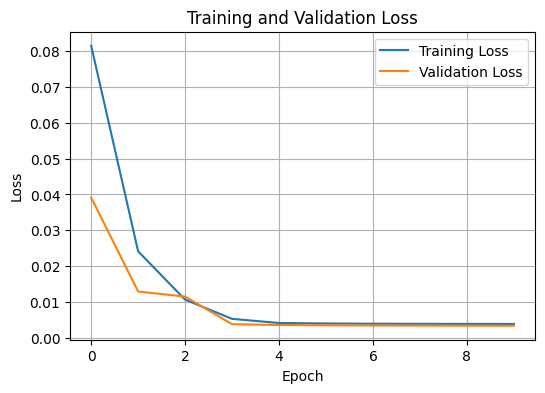

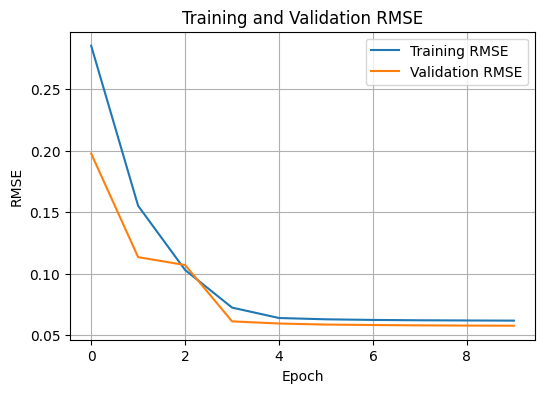

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

history recovery

In [ ]:
import pickle
with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
print(history)

In [ ]:
with open('/trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)

recovery plot

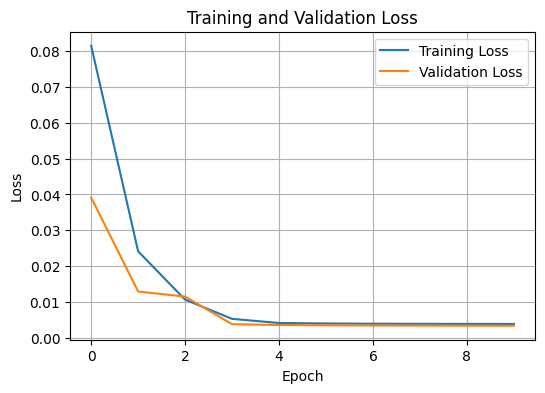

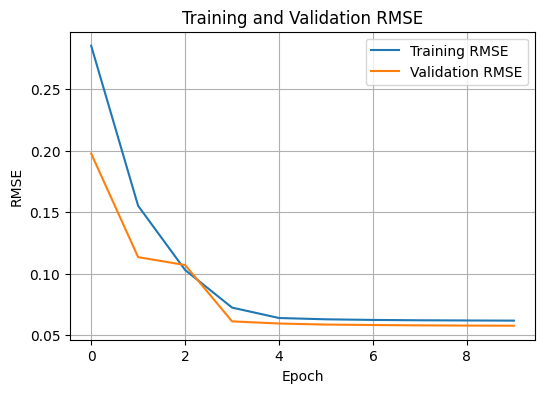

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

### Export area of interest for prediction

In [ ]:
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
Canada = countries.filter(ee.Filter.eq('country_na', 'Canada')).geometry() # <class 'ee.geometry.Geometry'>
pred_region_geometry = Canada

In [ ]:
feature_img_lists = []
date_start_str = '2017-07-01'
pred_start = ee.Date(date_start_str)
pred_end = pred_start.advance(4, 'week')

for feature in feature_list:
  img_col = getImageCollection(feature['name'],pred_region_geometry, feature['band'])
  pred_img = img_col.filterDate(pred_start, pred_end).median().unitScale(feature['min'], feature['max'])
  feature_img_lists += [pred_img]
print(feature_img_lists)

[<ee.image.Image object at 0x7fe30068a080>, <ee.image.Image object at 0x7fe30068b0d0>, <ee.image.Image object at 0x7fe30068b490>, <ee.image.Image object at 0x7fe300796260>, <ee.image.Image object at 0x7fe30078fee0>, <ee.image.Image object at 0x7fe300439b70>, <ee.image.Image object at 0x7fe3007959c0>]


In [ ]:
predict_image = feature_img_lists[0]
for idx in range(1, len(feature_img_lists)):
  # Combine all bands sampled from the same time to featureStack
  predict_image = ee.Image.cat([predict_image, feature_img_lists[idx]]).float()
# predict_image

In [ ]:
def doExport(output_folder, predict_image, out_file_name, kernel_buffer, region):
    """Run the image export task.  Block until complete.
    """
    # Define the export task using the Earth Engine Python API.
    task = ee.batch.Export.image.toCloudStorage(
        image=predict_image,  # Select specific bands from the 'featureStack' Image.
        description=out_file_name,  # Description for the export task.
        bucket=OUTPUT_BUCKET,  # The destination Cloud Storage bucket.
        fileNamePrefix=output_folder + '/' + out_file_name,  # File name prefix for the exported images.
        region=region.getInfo()['coordinates'],  # The bounding region for the export task.
        scale=SAMPLE_RESOLUTION,  # The spatial resolution in meters for the exported images.
        fileFormat='TFRecord',  # File format for the exported images (TensorFlow Record).
        maxPixels=1e10,  # Maximum number of pixels allowed for the export task.
        formatOptions={
            'patchDimensions': KERNEL_SHAPE,  # Dimensions of the image patches for segmentation.
            'kernelSize': kernel_buffer,  # Size of the kernel buffer for segmentation.
            'compressed': True,  # Enable compression for the exported images.
            'maxFileSize': 104857600  # Maximum file size for each exported image in bytes.
        }
    )
    print(output_folder + '/' + out_file_name)
    # Start the export task.
    task.start()

    # Block until the task completes.
    print('Running image export to Cloud Storage...')
    import time
    while task.active():
        print('Polling for task (id: {}).'.format(task.id))
        time.sleep(30)

    # Check if the export task encountered an error.
    if task.status()['state'] != 'COMPLETED':
        print(f"Error with image export {task.status()['state']}")
    else:
        print('Image export completed.')

In [ ]:
OUTPUT_FOLDER = "fcnn-demo"
SAMPLE_RESOLUTION = 1000
pred_region_list = {
    'C10784_Cariboo' : ee.Geometry.Polygon(
    [[[-120.20174153645834,49.14285216617945], 
    [-120.20174153645834,52.81447433261997], 
    [-123.64644368489584,52.81447433261997],     
    [-123.64644368489584,49.14285216617945]]],  None, False),
    'C50647_Cariboo' : ee.Geometry.Polygon(
    [[[-122.67502848307292,51.70668359537607], 
    [-122.67502848307292,52.94329853797672], 
    [-123.64182535807292,52.94329853797672],     
    [-123.64182535807292,51.70668359537607]]],  None, False),
    'K20637_Kamloops' : ee.Geometry.Polygon(
    [[[-120.79718831380208,50.95921791042009], 
    [-120.79718831380208,51.33826037858265], 
    [-121.63214925130208,51.33826037858265],     
    [-121.63214925130208,50.95921791042009]]],  None, False),
    'Canada': ee.Geometry.Polygon(
    [[[-54.01082156378895,41.82407998674415],
    [-54.01082156378895,73.24711433802126],
    [-161.23738406378894,73.24711433802126],
    [-161.23738406378894,41.82407998674415]]], None, False)
    
}
half_kernel_size = [128, 128]

pred_region = ee.Geometry.Polygon(
    [[[-54.01082156378895,41.82407998674415],
    [-54.01082156378895,73.24711433802126],
    [-161.23738406378894,73.24711433802126],
    [-161.23738406378894,41.82407998674415]]], None, False)

In [ ]:
type(pred_region_list['C10784_Cariboo'])

ee.geometry.Geometry

In [ ]:
doExport(OUTPUT_FOLDER, predict_image, 'Canada', half_kernel_size, pred_region_list['Canada'])
# for region_name, region_poly in pred_region_list.items():
#     doExport(OUTPUT_FOLDER, predict_image, region_name, KERNEL_SIZE, region_poly)

fcnn-demo/Canada
Running image export to Cloud Storage...
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).
Polling for task (id: PAMQDJ5XSSLNETJT46LBOGNN).


KeyboardInterrupt: 

In [ ]:
# doExport(OUTPUT_FOLDER, predict_image, 'K20637_Kamloops', half_kernel_size, pred_region_list['K20637_Kamloops'])

### Import area and predict with trained model

In [ ]:
def doPrediction(in_folder, in_filename, out_folder, out_filename, gee_folder, kernel_buffer):
  """Perform inference on exported imagery, upload to Earth Engine.
  """

  print('Looking for TFRecord files...')

  # Get a list of all the files in the output bucket.
  filesList = !gsutil ls 'gs://'{OUTPUT_BUCKET}'/'{in_folder}

  # Get only the files generated by the image export.
  exportFilesList = [s for s in filesList if in_filename in s]

  # Get the list of image files and the JSON mixer file.
  imageFilesList = []
  jsonFile = None
  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f

  # Make sure the files are in the right order.
  imageFilesList.sort()

  from pprint import pprint
  pprint(f'imageFilesList {imageFilesList}')
  # print(f'jsonFile {jsonFile}')

  import json
  # Load the contents of the mixer file to a JSON object.
  jsonText = !gsutil cat {jsonFile}
  # print(f'jsonText{jsonText}')
  # Get a single string w/ newlines from the IPython.utils.text.SList
  mixer = json.loads(jsonText.nlstr)
  pprint(mixer)
  patches = mixer['totalPatches']

  # Get set up for prediction.
  x_buffer = int(kernel_buffer[0] / 2)
  y_buffer = int(kernel_buffer[1] / 2)

  buffered_shape = [
      KERNEL_SHAPE[0] + kernel_buffer[0],
      KERNEL_SHAPE[1] + kernel_buffer[1]]

  imageColumns = [
    tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32)
      for k in BANDS
  ]

  imageFeaturesDict = dict(zip(BANDS, imageColumns))

  def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, imageFeaturesDict)

  def toTupleImage(inputs):
    inputsList = [inputs.get(key) for key in BANDS]
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked

   # Create a dataset from the TFRecord file(s) in Cloud Storage.
  imageDataset = tf.data.TFRecordDataset(imageFilesList, compression_type='GZIP')
  imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
  imageDataset = imageDataset.map(toTupleImage).batch(1)

  # Perform inference.
  print('Running predictions...')
  predictions = m.predict(imageDataset, steps=patches, verbose=1)
  # print(predictions[0])

  print('Writing predictions...')
  # out_image_base = 'shufeitest123'
  out_image_file = 'gs://' + OUTPUT_BUCKET + '/' + out_folder + '/' + out_filename + '.TFRecord'
  
  print(out_image_file)
  writer = tf.io.TFRecordWriter(out_image_file)
  patches = 0
    
  for predictionPatch in predictions:
    print('Writing patch ' + str(patches) + '...')
    predictionPatch = predictionPatch[
        x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]
    
    # print(f'prediction patch {predictionPatch}')
    # Create an example.
    example = tf.train.Example(
      features=tf.train.Features(
        feature={
          'T21': tf.train.Feature(
              float_list=tf.train.FloatList(
                  value=predictionPatch.flatten()))
        }
      )
    )
    # Write the example.
    writer.write(example.SerializeToString())
    print('finish writing patch ' + str(patches) + '...')
    patches += 1


  #writer.close()
  print(f'fin writing')

  # Start the upload.
  out_image_asset = gee_folder + '/' + out_filename
  !earthengine upload image --asset_id={out_image_asset} {out_image_file} {jsonFile}

In [ ]:
# Run the prediction.
# doPrediction(OUTPUT_FOLDER, 'C10784_Cariboo', OUTPUT_FOLDER, 'C10784_Cariboo_result_Apr', 'users/zhengyant', half_kernel_size)
# doPrediction(OUTPUT_FOLDER, 'C10784_Cariboo', OUTPUT_FOLDER, 'C10784_Cariboo_result_Apr', 'users/jindacz', half_kernel_size)
doPrediction(OUTPUT_FOLDER, 'Canada', OUTPUT_FOLDER, 'Canada_result', 'users/jindacz', half_kernel_size)

Looking for TFRecord files...
("imageFilesList ['gs://6140-output-bucket/fcnn-demo/Canada00000.tfrecord.gz', "
 "'gs://6140-output-bucket/fcnn-demo/Canada00001.tfrecord.gz', "
 "'gs://6140-output-bucket/fcnn-demo/Canada00002.tfrecord.gz', "
 "'gs://6140-output-bucket/fcnn-demo/Canada00003.tfrecord.gz', "
 "'gs://6140-output-bucket/fcnn-demo/Canada00004.tfrecord.gz', "
 "'gs://6140-output-bucket/fcnn-demo/Canada00005.tfrecord.gz', "
 "'gs://6140-output-bucket/fcnn-demo/Canada00006.tfrecord.gz', "
 "'gs://6140-output-bucket/fcnn-demo/Canada00007.tfrecord.gz', "
 "'gs://6140-output-bucket/fcnn-demo/Canada00008.tfrecord.gz', "
 "'gs://6140-output-bucket/fcnn-demo/Canada00009.tfrecord.gz', "
 "'gs://6140-output-bucket/fcnn-demo/Canada00010.tfrecord.gz', "
 "'gs://6140-output-bucket/fcnn-demo/Canada00011.tfrecord.gz', "
 "'gs://6140-output-bucket/fcnn-demo/Canada00012.tfrecord.gz', "
 "'gs://6140-output-bucket/fcnn-demo/Canada00013.tfrecord.gz', "
 "'gs://6140-output-bucket/fcnn-demo/Canada0

2023-08-14 04:33:48.876849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [30]
	 [[{{node Placeholder/_0}}]]


736/736 [==============================] - 28s 38ms/step
Writing predictions...
gs://6140-output-bucket/fcnn-demo/Canada_result.TFRecord
Writing patch 0...
finish writing patch 0...
Writing patch 1...
finish writing patch 1...
Writing patch 2...
finish writing patch 2...
Writing patch 3...
finish writing patch 3...
Writing patch 4...
finish writing patch 4...
Writing patch 5...
finish writing patch 5...
Writing patch 6...
finish writing patch 6...
Writing patch 7...
finish writing patch 7...
Writing patch 8...
finish writing patch 8...
Writing patch 9...
finish writing patch 9...
Writing patch 10...
finish writing patch 10...
Writing patch 11...
finish writing patch 11...
Writing patch 12...
finish writing patch 12...
Writing patch 13...
finish writing patch 13...
Writing patch 14...
finish writing patch 14...
Writing patch 15...
finish writing patch 15...
Writing patch 16...
finish writing patch 16...
Writing patch 17...
finish writing patch 17...
Writing patch 18...
finish writing pa

In [ ]:
user_folder = 'users/jindacz'
print(user_folder)

users/jindacz


In [ ]:
# out_image = ee.Image(user_folder + '/' + bj_image_base)
out_image = ee.Image(f'{user_folder}/Canada_result')
mapid = out_image.getMapId({'min': 0, 'max': 1, 'palette': ['red', 'orange', 'yellow']})
map = folium.Map(location=[53.81667309827828, -120.09501953125])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='predicted T21',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

export prediction to CSV

In [ ]:
pred_values = out_image.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=pred_region,
    scale=926.625433055833,  # The scale from the image's 'crs_transform'
    maxPixels=9999999999
)

t21_list = pred_values.get('T21').getInfo()

# Convert the list of pixel values to a pandas DataFrame
df = pd.DataFrame(t21_list, columns=['prediction'])

# Save the DataFrame as a CSV file
df.to_csv('prediction_results_Cariboo.csv', index=False)

In [ ]:
print(pred_values.get('T21'))

ee.ComputedObject({
  "functionInvocationValue": {
    "functionName": "Dictionary.get",
    "arguments": {
      "dictionary": {
        "functionInvocationValue": {
          "functionName": "Image.reduceRegion",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          -120.20174153645834,
                          49.14285216617945
                        ],
                        [
                          -120.20174153645834,
                          52.81447433261997
                        ],
                        [
                          -123.64644368489584,
                          52.81447433261997
                        ],
                        [
                          -123.646443684